In [1]:
from analysis.loaders import load_all_triax
from analysis.metrics import (
    compute_nmv, compute_nvd, compute_av,
    compute_vdv, compute_vdv_ratios
)
from analysis.categories import categorize
from analysis.plotting import (
    plot_comfort_thresholds,
    plot_vdv_over_time,
    plot_ratio_comparison,
    plot_compare_all_metrics,
    plot_comfort_timeseries,
    plot_iso_timeseries
)

import numpy as np
import pandas as pd

In [2]:
# Category definitions Nmv, Nvd, Nva
categories = [
    ((0, 1.5), 'Very Comfortable'),
    ((1.5, 2.5), 'Comfortable'),
    ((2.5, 3.5), 'Medium'),
    ((3.5, 4.5), 'Uncomfortable'),
    ((4.5, 6.0), 'Very Uncomfortable')
]

# Category definitions Ccy, Ccz - might need to add to categories.py
cats_cont = [
    ((0,0.2), 'Very Comfortable'),
    ((0.2,0.3), 'Comfortable'),
    ((0.3,0.4), 'Medium'),
    ((0.4,1), 'Less Comfortable')
]

# Pair floor & seat triaxials (floor,seat) - looks like the categories has a .py associated with it so CNR might have to add something to make this useable
pairs = [
    ((1,6), 'Motor Truck'),
    ((3,2), 'Between Trucks'),
    ((5,4), 'Center Truck')
]



In [3]:
# Load data - will need to load paired triaxes (floor = p, seat = a&d)
non_rave, rave = load_all_triax("data/")

In [4]:
triaxes_metrics = {str(num): {"N_MV": None, 
                              "N_VD": None, 
                              "av": None, 
                              "av_5s": None, 
                              "Cx": None, 
                              "Cy": None, 
                              "Cz": None
                        }
                                for num in range(1, 7)
            }

triaxes_metrics["N_VA"] = None

In [5]:
for triax in range(1, 7):
    rave_curr = rave[str(triax)]
    
    if rave_curr is None:
        continue

    # Calculate metrics for each triaxial
    # Every 5th running average
    if triax == 5:
        x5 = rave_curr["4"].iloc[4::5]
        y5 = rave_curr["5"].iloc[4::5]
        z5 = rave_curr["6"].iloc[4::5]
    else:
        x5 = rave_curr["1"].iloc[4::5]
        y5 = rave_curr["2"].iloc[4::5]
        z5 = rave_curr["3"].iloc[4::5]

    Cx = x5['ISO-WD']
    Cy = y5['ISO-WD']
    Cz = z5['EN-WB']
    triaxes_metrics[str(triax)]["Cx"] = Cx
    triaxes_metrics[str(triax)]["Cy"] = Cy
    triaxes_metrics[str(triax)]["Cz"] = Cz


    # Percentile inputs
    Ax95 = np.percentile(Cx, 95)
    Ay95 = np.percentile(Cy, 95)
    Az95 = np.percentile(Cz, 95)
    Ax50 = np.percentile(Cx, 50)
    Ay50 = np.percentile(Cy, 50)
    Az50 = np.percentile(Cz, 50)

    # Calculate comfort indices
    N_MV = compute_nmv(Ax95, Ay95, Az95)
    N_VD = compute_nvd(Ax50, Ay50, Az50, Ay95)
    triaxes_metrics[str(triax)]["N_MV"] = N_MV
    triaxes_metrics[str(triax)]["N_VD"] = N_VD

    print(f"N_M_V = {N_MV:.2f} → {categorize(N_MV, categories)}")
    print(f"N_V_D = {N_VD:.2f} → {categorize(N_VD, categories)}")

N_M_V = 0.89 → Very Comfortable
N_V_D = 0.92 → Very Comfortable
N_M_V = 0.87 → Very Comfortable
N_V_D = 1.01 → Very Comfortable
N_M_V = 0.83 → Very Comfortable
N_V_D = 0.85 → Very Comfortable
N_M_V = 0.86 → Very Comfortable
N_V_D = 0.92 → Very Comfortable


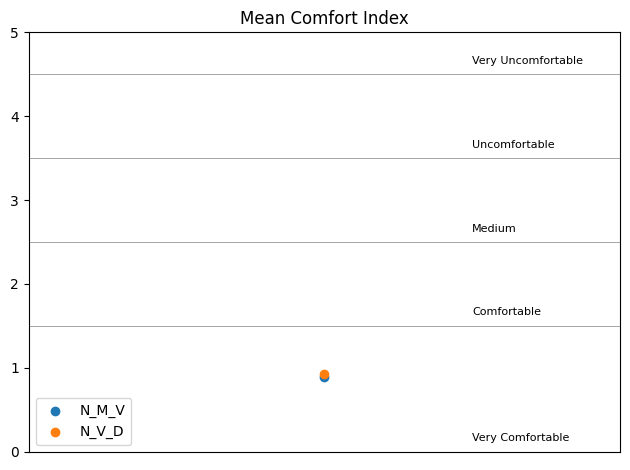

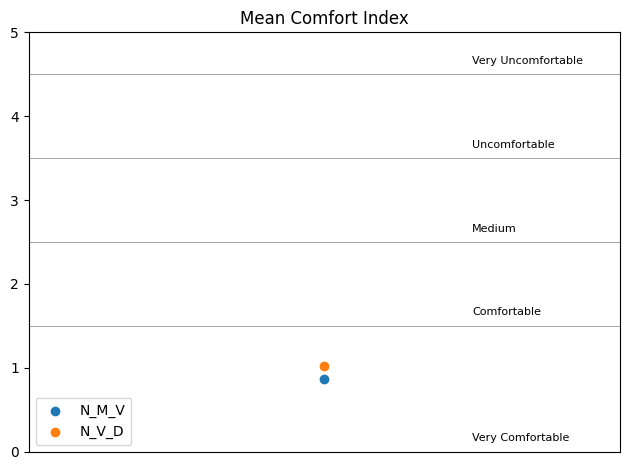

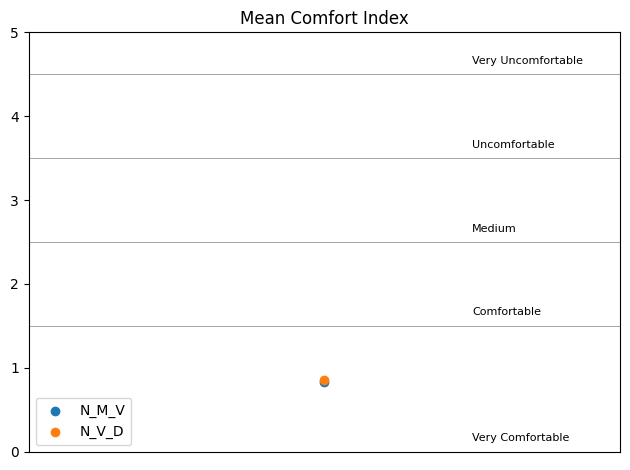

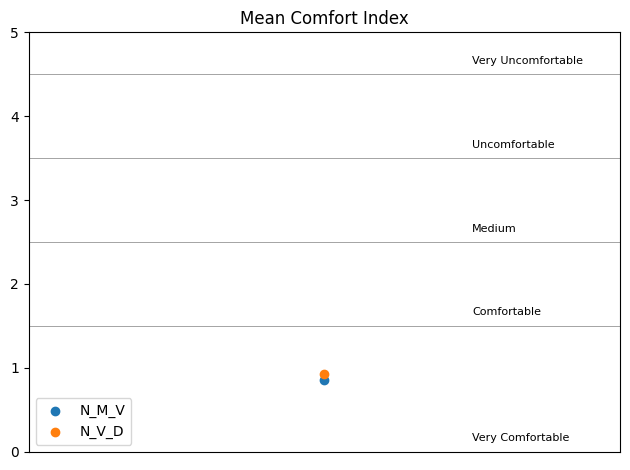

In [6]:

for triax in range(1, 7):

    N_MV = triaxes_metrics[str(triax)]["N_MV"]
    N_VD = triaxes_metrics[str(triax)]["N_VD"]

    if N_MV is None or N_VD is None:
        continue

    plot_comfort_thresholds(N_MV, N_VD, categories)




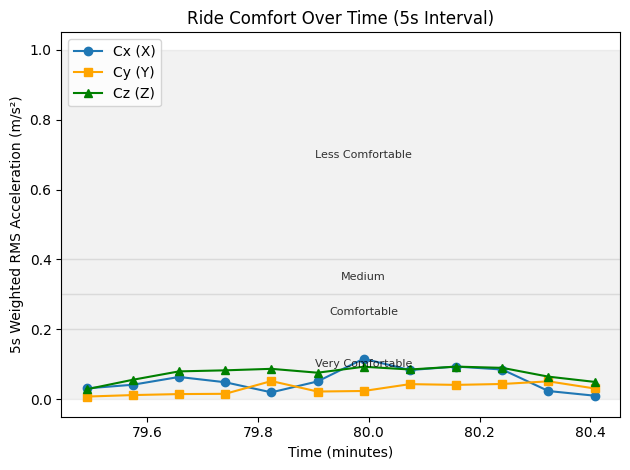

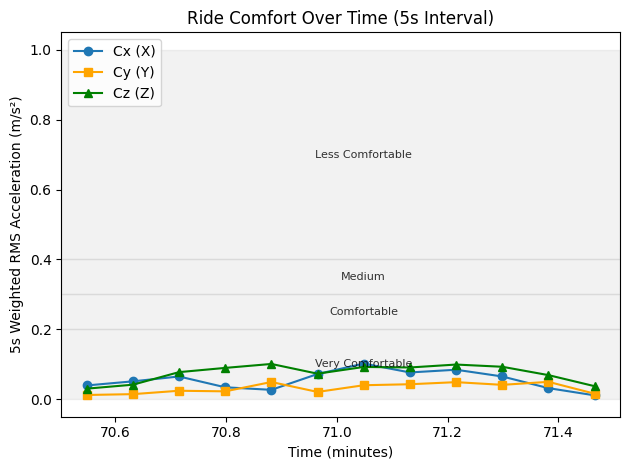

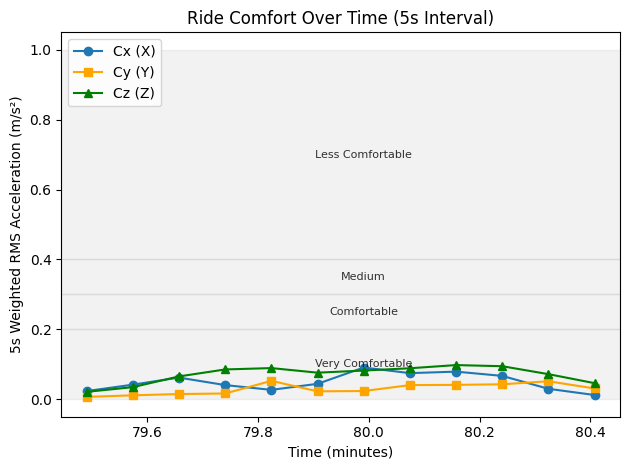

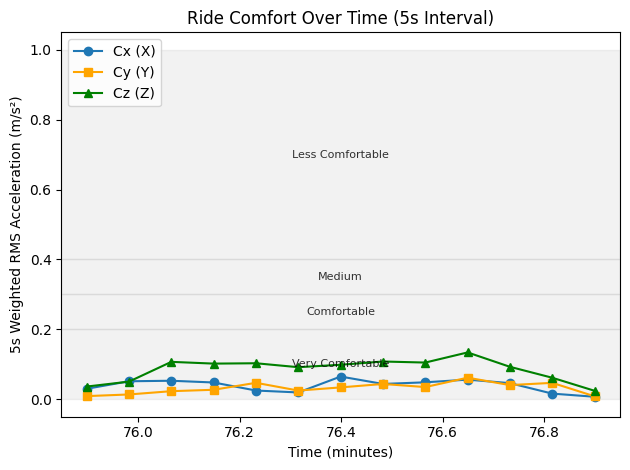

In [7]:
for triax in range(1, 7):
    raw = non_rave[str(triax)]
    
    if raw is None:
        continue

    # Full time vector 
    if triax == 5:
        t_all = pd.to_timedelta(raw["4"]['Number'], unit='s')
    else:
        t_all = pd.to_timedelta(raw["1"]['Number'], unit='s')
    # Downsampled time vector to match 5s interval RAVE slices
    t_5s = t_all[4::5]
    t_5s_minutes = t_5s.dt.total_seconds() / 60
    # 5s signals plot
    Cx, Cy, Cz = triaxes_metrics[str(triax)]["Cx"], triaxes_metrics[str(triax)]["Cy"], triaxes_metrics[str(triax)]["Cz"]
    plot_comfort_timeseries(t_5s_minutes, Cx, Cy, Cz)


In [8]:
#### For av calculation, note that I'm not implementing the kb control flow ###

for triax in range(1, 7):
    raw = non_rave[str(triax)]
    
    if raw is None:
        continue
    
    # Compute AV
    if triax == 5:
        X_ISO = raw["4"]['ISO-WD']
        Y_ISO = raw["5"]['ISO-WD']
        Z_ISO = raw["6"]['ISO-WB']
    else:
        X_ISO = raw["1"]['ISO-WD']
        Y_ISO = raw["2"]['ISO-WD']
        Z_ISO = raw["3"]['ISO-WB']
    
    a_v = compute_av(X_ISO, Y_ISO, Z_ISO)
    triaxes_metrics[str(triax)]["av"] = a_v
    # Compute a_v 
    if triax == 5:
        a_v_5s = compute_av(rave[str(triax)]["4"]['ISO-WD'], rave[str(triax)]["5"]['ISO-WD'], rave[str(triax)]["6"]['ISO-WB'])
    else:
        a_v_5s = compute_av(rave[str(triax)]["1"]['ISO-WD'], rave[str(triax)]["2"]['ISO-WD'], rave[str(triax)]["3"]['ISO-WB'])
    
    triaxes_metrics[str(triax)]["av_5s"] = a_v_5s

    print(f"a_v (1s ISO composite) = {np.mean(a_v):.3f} m/s²")
    print(f"a_v_5s (from RAVE)      = {np.mean(a_v_5s):.3f} m/s²")



a_v (1s ISO composite) = 0.095 m/s²
a_v_5s (from RAVE)      = 0.096 m/s²
a_v (1s ISO composite) = 0.096 m/s²
a_v_5s (from RAVE)      = 0.098 m/s²
a_v (1s ISO composite) = 0.087 m/s²
a_v_5s (from RAVE)      = 0.088 m/s²
a_v (1s ISO composite) = 0.101 m/s²
a_v_5s (from RAVE)      = 0.102 m/s²


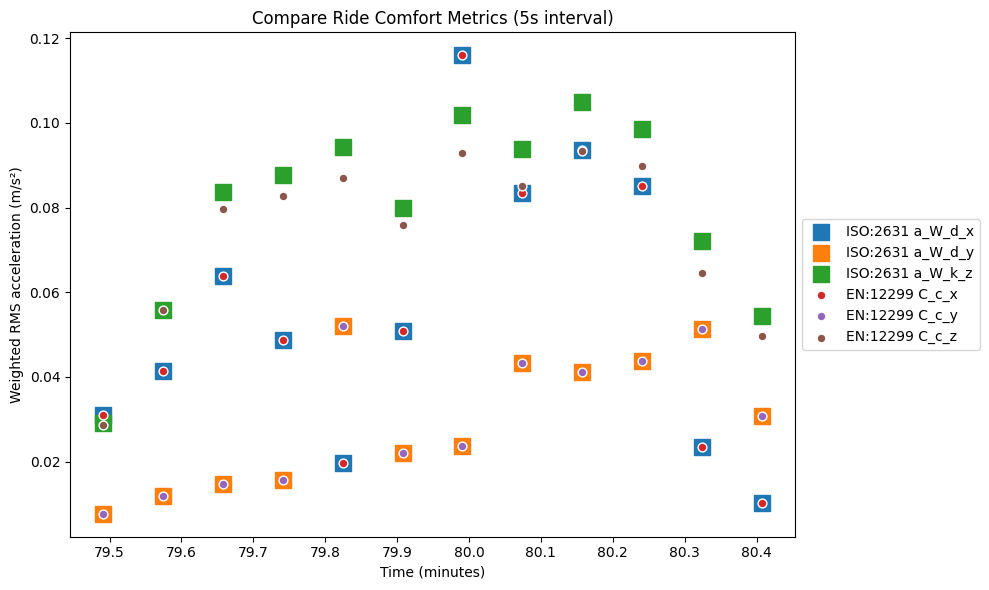

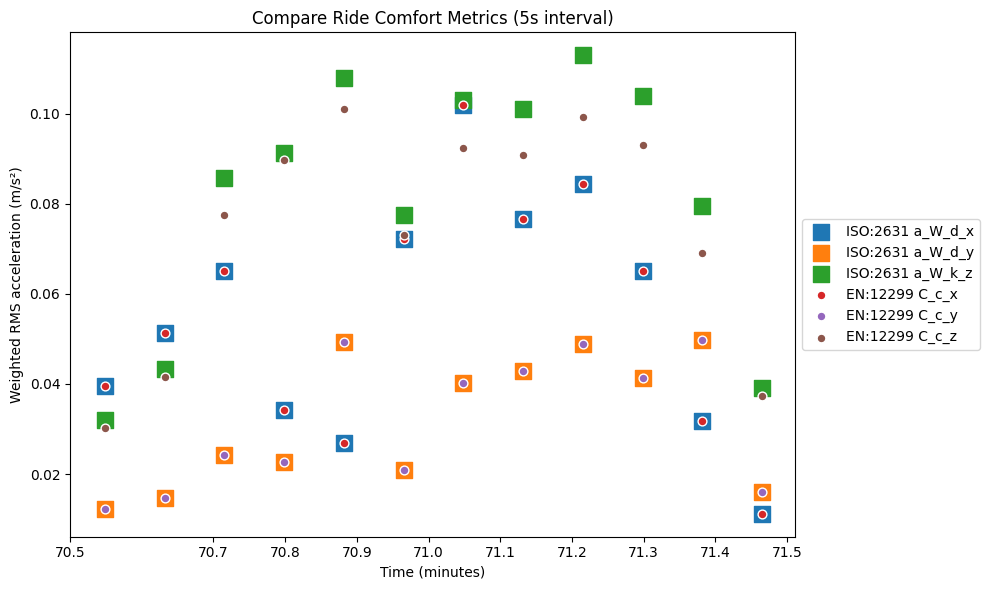

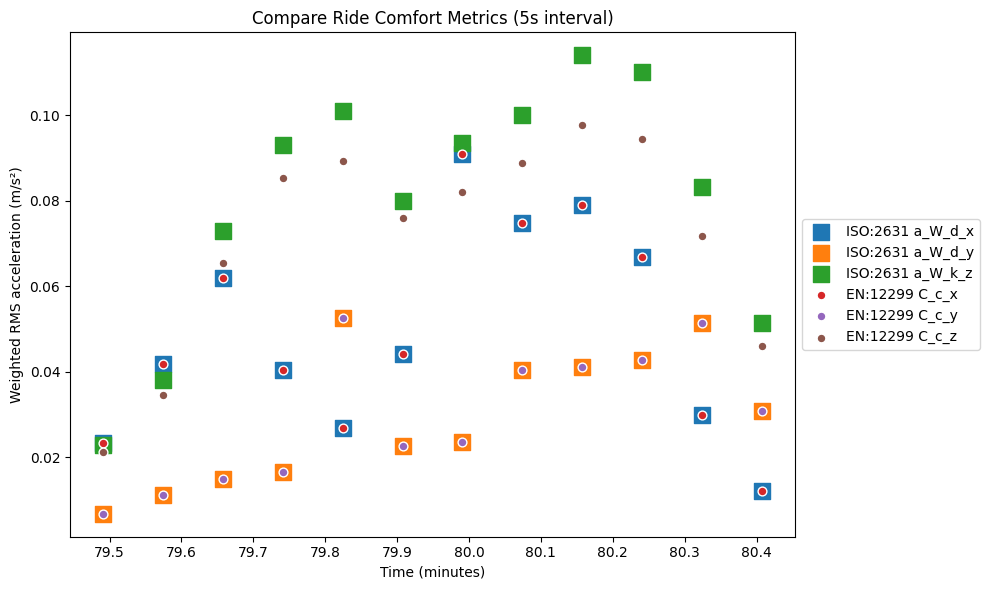

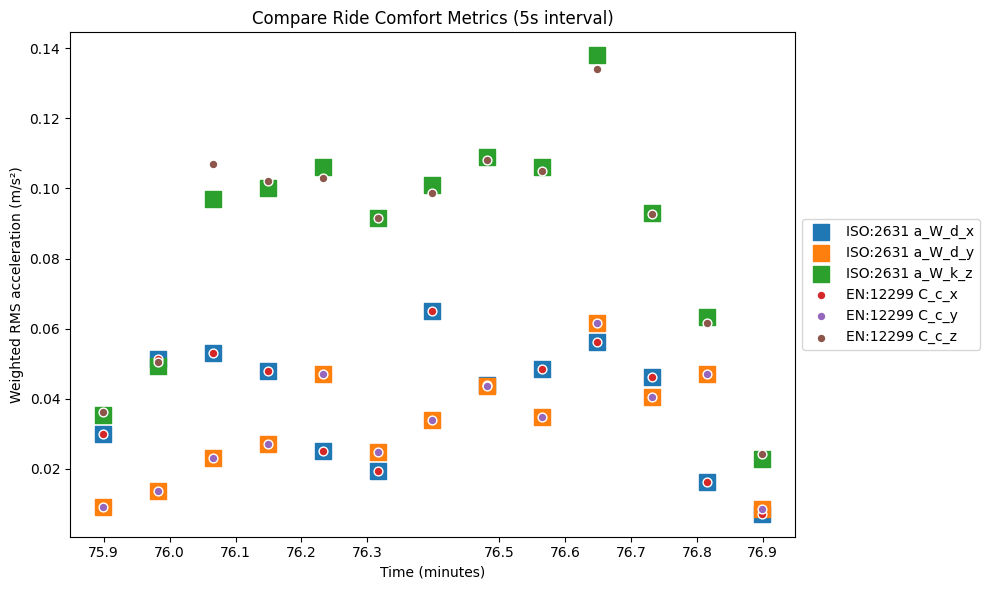

In [9]:
for triax in range(1, 7):
    rave_curr = rave[str(triax)]
    raw = non_rave[str(triax)]

    if raw is None or rave_curr is None:
        continue

    if triax == 5:
        t_5s_minutes = pd.to_timedelta(raw["4"]['Number'], unit='s')[4::5].dt.total_seconds() / 60

        x5 = rave_curr["4"]['ISO-WD'].iloc[4::5]
        y5 = rave_curr["5"]['ISO-WD'].iloc[4::5]
        z5 = rave_curr["6"]['ISO-WK'].iloc[4::5]
    else:
        t_5s_minutes = pd.to_timedelta(raw["1"]['Number'], unit='s')[4::5].dt.total_seconds() / 60

        x5 = rave_curr["1"]['ISO-WD'].iloc[4::5]
        y5 = rave_curr["2"]['ISO-WD'].iloc[4::5]
        z5 = rave_curr["3"]['ISO-WK'].iloc[4::5]
    
    plot_compare_all_metrics(
        t_5s_minutes,
        x5,
        y5,
        z5,
        triaxes_metrics[str(triax)]["Cx"], triaxes_metrics[str(triax)]["Cy"], triaxes_metrics[str(triax)]["Cz"]
    )


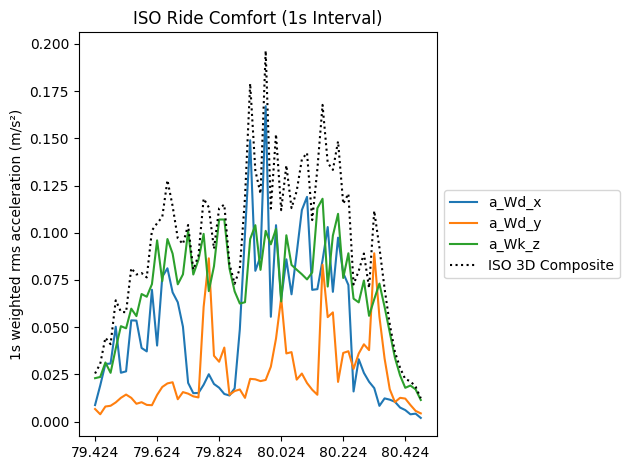

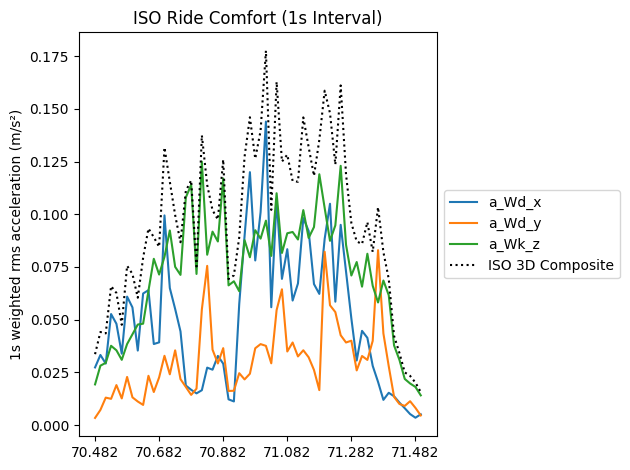

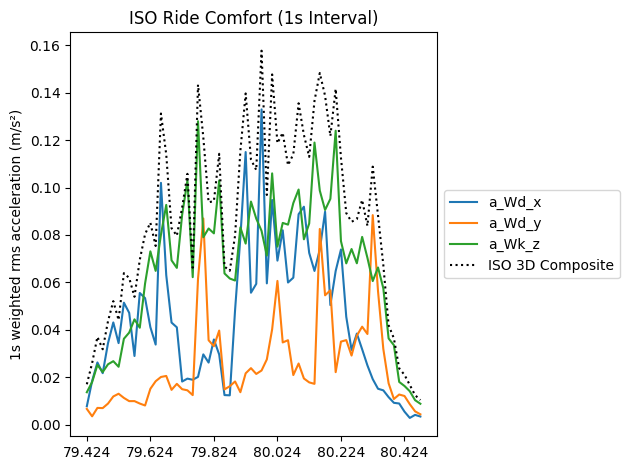

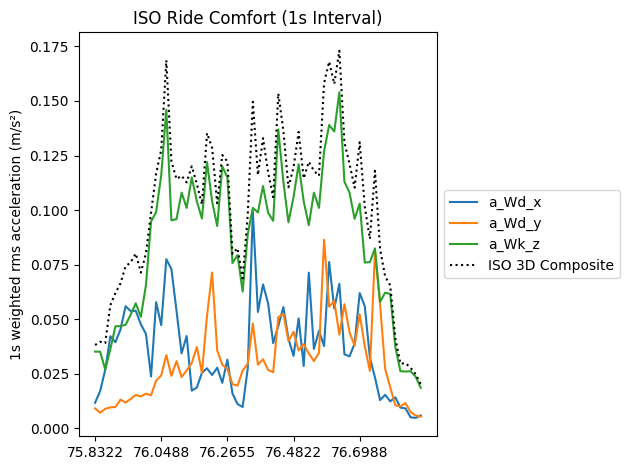

In [10]:
for triax in range(1, 7):
    raw = non_rave[str(triax)]

    if raw is None:
        continue
    
    if triax == 5:
        t_all = pd.to_timedelta(raw["4"]['Number'], unit='s')
        t_5s_minutes = pd.to_timedelta(raw["4"]['Number'], unit='s')[4::5].dt.total_seconds() / 60
        X_ISO = raw["4"]['ISO-WD']
        Y_ISO = raw["5"]['ISO-WD']
        Z_ISO = raw["6"]['ISO-WB']

    else:
        t_all = pd.to_timedelta(raw["1"]['Number'], unit='s')
        t_5s_minutes = pd.to_timedelta(raw["1"]['Number'], unit='s')[4::5].dt.total_seconds() / 60
        X_ISO = raw["1"]['ISO-WD']
        Y_ISO = raw["2"]['ISO-WD']
        Z_ISO = raw["3"]['ISO-WB']
    a_v = triaxes_metrics[str(triax)]["av"]
    a_v_5s = triaxes_metrics[str(triax)]["av_5s"]

    plot_iso_timeseries(t_all, X_ISO, Y_ISO, Z_ISO, a_v, a_v_5s, t_5s_minutes)

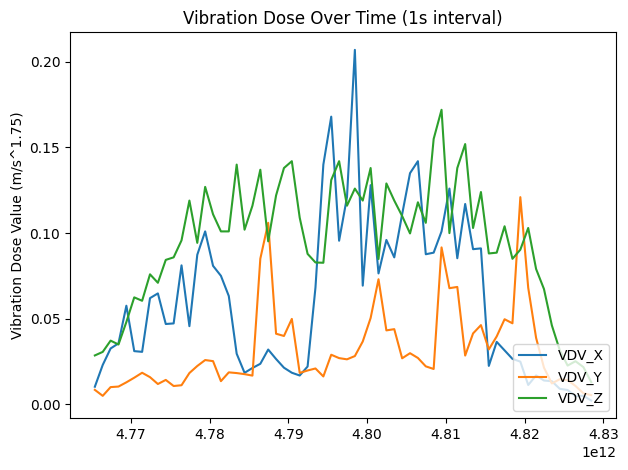

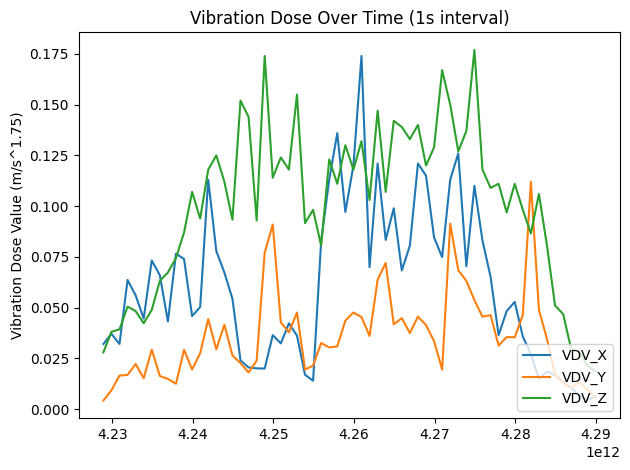

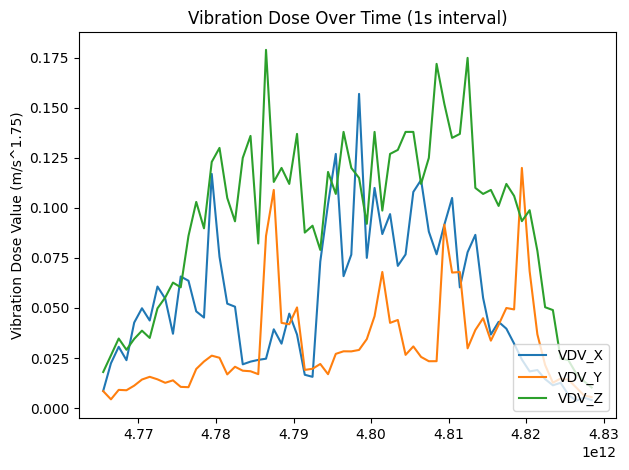

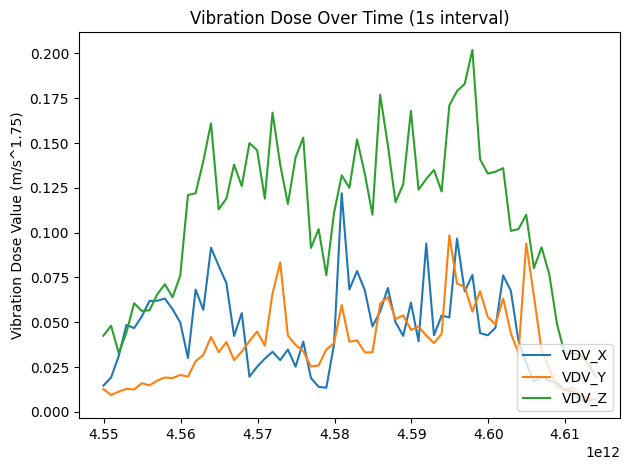

In [11]:
for triax in range(1, 7):
    raw = non_rave[str(triax)]
    
    if raw is None:
        continue
    
    if triax == 5:
        t_all = pd.to_timedelta(raw["4"]['Number'], unit='s')
        X_VDV = raw["4"]['WD4th_VDV']
        Y_VDV = raw["5"]['WD4th_VDV']
        Z_VDV = raw["6"]['WK4th_VDV']

    else:
        t_all = pd.to_timedelta(raw["1"]['Number'], unit='s')
        # VDV data
        X_VDV = raw["1"]['WD4th_VDV']
        Y_VDV = raw["2"]['WD4th_VDV']
        Z_VDV = raw["3"]['WK4th_VDV']
    plot_vdv_over_time(t_all, X_VDV, Y_VDV, Z_VDV)

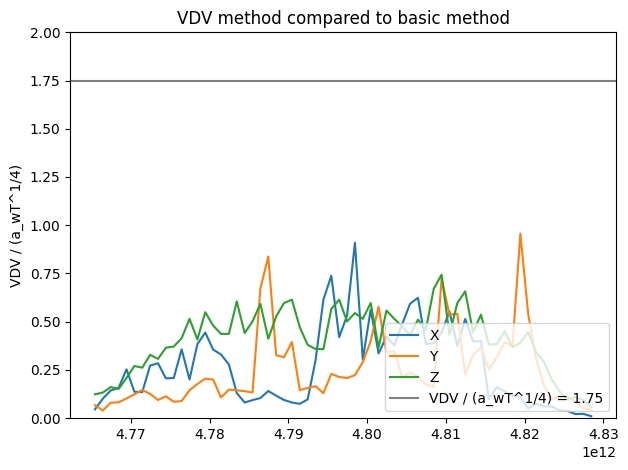

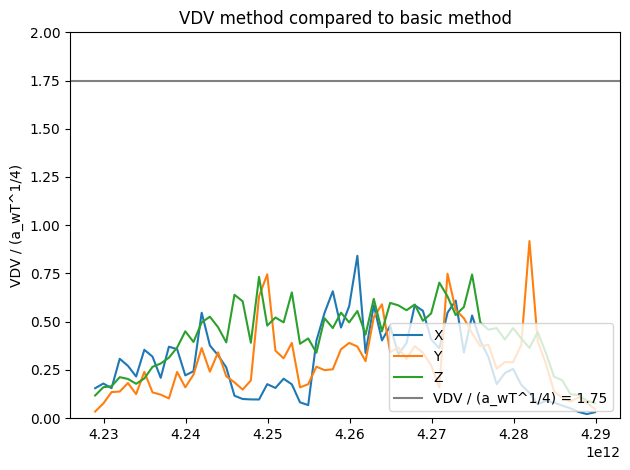

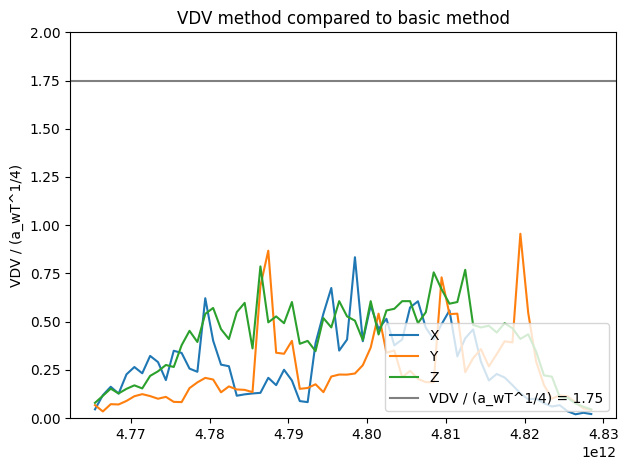

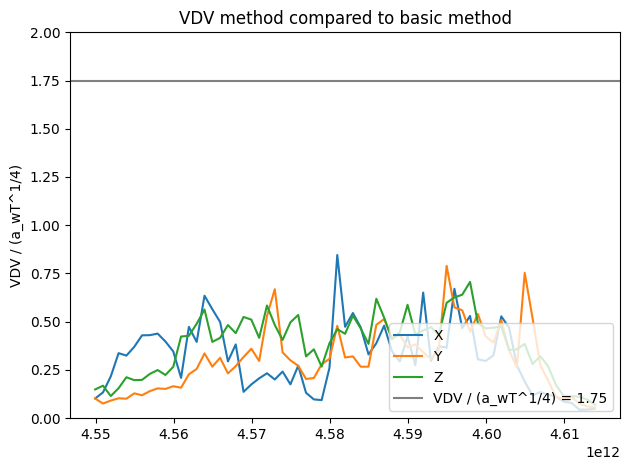

In [ ]:
for triax in range(1, 7):
    raw = non_rave[str(triax)]

    if raw is None:
        continue
    
    if triax == 5:
        t_all = pd.to_timedelta(raw["4"]['Number'], unit='s')
        X_VDV = raw["4"]['WD4th_VDV']
        Y_VDV = raw["5"]['WD4th_VDV']
        Z_VDV = raw["6"]['WK4th_VDV']
        X_ISO = raw["4"]['ISO-WD']
        Y_ISO = raw["5"]['ISO-WD']
        Z_ISO = raw["6"]['ISO-WB']

    else:
        t_all = pd.to_timedelta(raw["1"]['Number'], unit='s')
        # VDV data
        X_VDV = raw["1"]['WD4th_VDV']
        Y_VDV = raw["2"]['WD4th_VDV']
        Z_VDV = raw["3"]['WK4th_VDV']
        X_ISO = raw["1"]['ISO-WD']
        Y_ISO = raw["2"]['ISO-WD']
        Z_ISO = raw["3"]['ISO-WB']

    ratios = [
        compute_vdv_ratios(X_VDV, compute_vdv(X_ISO)),
        compute_vdv_ratios(Y_VDV, compute_vdv(Y_ISO)),
        compute_vdv_ratios(Z_VDV, compute_vdv(Z_ISO))
    ]
    plot_ratio_comparison(t_all, ratios, labels=['X', 'Y', 'Z'])